# Field Validation

In [166]:
import pandas as pd #reading dataset
import matplotlib as mpl    #plotting, visualization
import matplotlib.pyplot as plt
import tensorflow as tf #building model
from tensorflow.keras.models import Model
import numpy as np  #playing output with model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import joblib  
import json

import sys
sys.path.append('../../')   # Add parent directory to Python path
from utils.Preprocessing import *
from utils.Segmentation import *


In [168]:
#load processed data
df = pd.read_csv('../../data/test/Accelerometer_ziyi_with_curb_segmented_abnormal_changed.csv')
df

,curb_scene,start_time,end_time,Acc-Z_1,Acc-Z_2,Acc-Z_3,Acc-Z_4,Acc-Z_5,Acc-Z_6,Acc-Z_7,...,Acc-Z_91,Acc-Z_92,Acc-Z_93,Acc-Z_94,Acc-Z_95,Acc-Z_96,Acc-Z_97,Acc-Z_98,Acc-Z_99,Acc-Z_100
0,0,2025-03-28 16:00:48.289,2025-03-28 16:00:48.780,8.374924,8.274368,7.814682,8.034943,7.891296,8.073242,8.173798,...,8.078033,8.020569,8.011002,8.078033,8.020569,8.020569,7.953537,7.991852,8.087616,8.039734
1,0,2025-03-28 16:00:48.785,2025-03-28 16:00:49.277,8.030151,7.977478,8.020569,8.054092,8.020569,8.020569,7.987061,...,7.441177,7.259216,7.584824,7.536942,7.278366,7.254425,7.503433,7.704544,7.781158,7.742844
2,0,2025-03-28 16:00:49.284,2025-03-28 16:00:49.773,7.517792,7.723694,7.939178,7.718903,7.733276,7.508209,7.498642,...,6.689407,6.689407,6.459549,6.234497,5.750870,5.477936,5.722137,6.766022,7.991852,8.384491
3,0,2025-03-28 16:00:49.778,2025-03-28 16:00:50.270,8.633499,9.428360,10.046066,8.925583,7.010223,7.082046,6.885727,...,6.689407,8.609543,9.916779,8.930374,8.427597,8.173798,8.384491,7.412445,7.776367,8.011002
4,0,2025-03-28 16:00:50.275,2025-03-28 16:00:50.766,10.960663,10.577591,9.801865,7.599197,6.493073,8.561661,8.892059,...,9.284714,9.232040,8.437164,8.576035,9.030930,9.514557,9.265564,9.686935,10.113113,9.428360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,0,2025-03-28 16:22:59.826,2025-03-28 16:23:00.318,7.527374,7.082046,7.699753,8.097183,3.246536,10.180145,6.402100,...,8.264786,8.092407,8.743622,8.820236,8.465897,7.723694,7.182602,7.675812,8.078033,7.618347
2682,0,2025-03-28 16:23:00.324,2025-03-28 16:23:00.815,6.919251,7.096420,8.125916,8.643066,8.264786,7.790726,7.967911,...,7.843399,7.881714,7.987061,7.958328,7.948746,7.920013,7.872131,8.015793,8.135498,7.929596
2683,0,2025-03-28 16:23:00.821,2025-03-28 16:23:01.311,7.881714,7.838623,7.996628,8.011002,7.862564,7.833832,7.852982,...,7.833832,7.690170,7.733276,7.819458,7.800308,7.675812,7.551315,7.623138,7.704544,7.704544
2684,0,2025-03-28 16:23:01.319,2025-03-28 16:23:01.811,7.580048,7.465118,7.575256,7.637497,7.685394,7.450760,7.489059,...,7.733276,7.776367,7.642288,7.556107,7.642288,7.704544,7.690170,7.608780,7.575256,7.632721


In [160]:
# prepare data for model
# standardize data
scaler = StandardScaler()
test_data_scaled = scaler.fit_transform(df.iloc[:, 3:])
# Convert the scaled data back to DataFrames for further processing
test_data_scaled = pd.DataFrame(test_data_scaled, columns=df.columns[3:])
# Add the 'curb_scene', 'start_time', and 'end_time' columns back to the scaled DataFrames
test_data_scaled['curb_scene'] = df['curb_scene']
test_data_scaled['start_time'] = df['start_time']
test_data_scaled['end_time'] = df['end_time']
# Filter and slice the data
test_data_scaled_normal = test_data_scaled[test_data_scaled['curb_scene'] == 0].iloc[:, :-3]
test_data_scaled_abnormal = test_data_scaled[test_data_scaled['curb_scene'] == 1].iloc[:, :-3]
# Cast to float32
test_data_scaled_normal = test_data_scaled_normal.astype(np.float32)
test_data_scaled_abnormal = test_data_scaled_abnormal.astype(np.float32)
test_data_scaled_normal.shape, test_data_scaled_abnormal.shape



((2457, 100), (229, 100))

In [161]:
# Make predictions using autoencoder
autoencoder = tf.keras.models.load_model('../../models/autoencoder_best.keras')
with open('../../models/autoencoder_thresholds.json', 'r') as f:
    loaded_thresholds = json.load(f)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


C:\Users\liuzi\AppData\Local\Temp\ipykernel_5524\2162391532.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


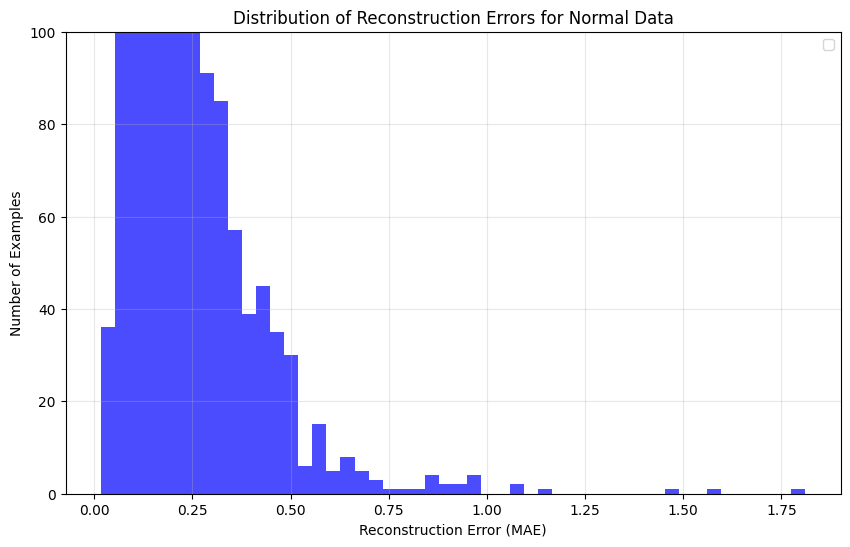

In [162]:
# Plot reconstruction error distribution for normal training data
reconstructions_normal = autoencoder.predict(test_data_scaled_normal)
train_loss_normal = tf.keras.losses.mae(reconstructions_normal, test_data_scaled_normal)

plt.figure(figsize=(10, 6))
plt.hist(train_loss_normal, bins=50, color='blue', alpha=0.7)

plt.title('Distribution of Reconstruction Errors for Normal Data', fontsize=12)
plt.xlabel('Reconstruction Error (MAE)', fontsize=10)
plt.ylabel('Number of Examples', fontsize=10)
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.legend()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


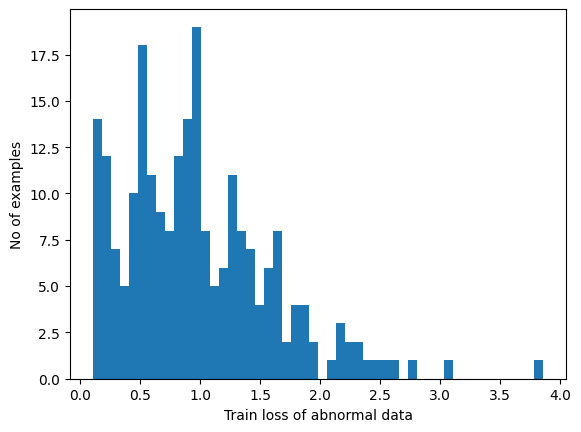

In [163]:
#Plot the reconstruction error on abnormal data from the training set
reconstructions_abnormal = autoencoder.predict(test_data_scaled_abnormal)
train_loss_abnormal = tf.keras.losses.mae(reconstructions_abnormal, test_data_scaled_abnormal)

plt.hist(train_loss_abnormal[None,:], bins=50)
plt.xlabel("Train loss of abnormal data")
plt.ylabel("No of examples")
plt.show()

In [164]:
# Find indices where reconstruction error is less than 0.5
low_reconstruction_indices = np.where(train_loss_abnormal < 0.5)[0]

# Get the indices of abnormal samples in the original dataframe
abnormal_mask = df['curb_scene'] == 1
abnormal_indices = df[abnormal_mask].index

# Map the indices from abnormal subset to original dataframe indices
original_indices = abnormal_indices[low_reconstruction_indices]

print("\nCorresponding indices in original dataframe:")
print(original_indices)



Corresponding indices in original dataframe:
Index([ 131,  132,  240,  279,  280,  520,  521,  687,  888,  889,  891, 1164,
       1172, 1206, 1207, 1270, 1271, 1272, 1273, 1415, 1416, 1492, 1493, 1494,
       1495, 1630, 1635, 1931, 2214, 2224, 2301, 2391, 2392, 2397, 2399, 2410,
       2417, 2419, 2420, 2427, 2429, 2461, 2464, 2466, 2473, 2481, 2491, 2494,
       2496, 2506, 2571],
      dtype='int64')


In [102]:
# Add the loss values back to the original DataFrame
df.loc[df['curb_scene'] == 0, 'loss'] = train_loss_normal.numpy()
df.loc[df['curb_scene'] == 1, 'loss'] = train_loss_abnormal.numpy()

In [103]:
df.iloc[680:687]

,curb_scene,start_time,end_time,Acc-Z_1,Acc-Z_2,Acc-Z_3,Acc-Z_4,Acc-Z_5,Acc-Z_6,Acc-Z_7,...,Acc-Z_92,Acc-Z_93,Acc-Z_94,Acc-Z_95,Acc-Z_96,Acc-Z_97,Acc-Z_98,Acc-Z_99,Acc-Z_100,loss
680,0,2025-03-28 16:06:25.632,2025-03-28 16:06:26.125,12.339722,10.817001,7.694961,4.702210,6.732498,13.862427,12.478577,...,10.146622,10.869675,7.508209,7.551315,9.327805,13.474564,9.514557,6.363785,5.554550,0.086596
681,0,2025-03-28 16:06:26.132,2025-03-28 16:06:28.626,8.231262,8.638275,5.085281,5.453995,5.875366,11.487381,7.680603,...,4.702210,-0.962463,-8.293518,-8.130707,-1.742981,2.652771,-3.011902,-5.319916,-0.569824,0.835027
682,0,2025-03-28 16:06:26.578,2025-03-28 16:06:27.067,4.453217,5.291183,10.773910,7.671021,7.570465,6.799530,8.298309,...,7.149094,6.114792,6.751648,9.849747,8.877701,4.587295,6.110001,9.706100,8.729263,0.077812
683,0,2025-03-28 16:06:27.072,2025-03-28 16:06:27.564,6.689407,7.556107,7.331039,10.218460,8.255203,3.447647,5.410889,...,9.533707,10.390839,11.003754,10.405197,7.599197,8.288727,9.447525,9.993393,7.560883,0.078769
684,0,2025-03-28 16:06:27.569,2025-03-28 16:06:28.062,9.279922,9.500198,6.306320,8.394073,6.818680,7.331039,7.943955,...,9.150635,5.597641,6.612778,8.245636,11.822571,3.485962,6.430832,7.862564,10.395630,0.119005
685,0,2025-03-28 16:06:28.065,2025-03-28 16:06:34.516,9.227249,8.916000,6.660675,6.502655,7.776367,6.689407,7.632721,...,9.548080,7.331039,8.192963,5.980713,8.346191,7.680603,8.925583,6.210556,8.595184,0.062678
686,1,2025-03-28 16:06:28.626,2025-03-28 16:06:29.118,17.827225,25.335450,23.549362,20.570984,17.741043,34.222717,28.366500,...,19.426560,10.888824,-0.842758,-0.689529,8.872910,18.377900,9.246414,-5.473145,-7.565674,1.336155


In [133]:
indices = [2215,2216,2225]
df.iloc[indices, df.columns.get_loc('curb_scene')] = 0

In [141]:
df.iloc[2470, df.columns.get_loc('curb_scene')] = 0

In [145]:
# Alternatively, for better notebook display:
df_selected = df[['curb_scene', 'start_time', 'loss']]
df_selected.iloc[2560:2580]

,curb_scene,start_time,loss
2560,0,2025-03-28 16:21:59.183,0.237847
2561,0,2025-03-28 16:21:59.680,0.552764
2562,0,2025-03-28 16:22:00.176,0.273036
2563,0,2025-03-28 16:22:00.673,0.418312
2564,0,2025-03-28 16:22:01.169,0.407522
2565,0,2025-03-28 16:22:01.665,0.104576
2566,0,2025-03-28 16:22:02.162,0.312573
2567,0,2025-03-28 16:22:02.658,0.458279
2568,0,2025-03-28 16:22:03.154,0.469416
2569,0,2025-03-28 16:22:03.651,0.323507


In [88]:
df.drop(columns=['loss'], inplace=True)

In [89]:
df.head()

,curb_scene,start_time,end_time,Acc-Z_1,Acc-Z_2,Acc-Z_3,Acc-Z_4,Acc-Z_5,Acc-Z_6,Acc-Z_7,...,Acc-Z_91,Acc-Z_92,Acc-Z_93,Acc-Z_94,Acc-Z_95,Acc-Z_96,Acc-Z_97,Acc-Z_98,Acc-Z_99,Acc-Z_100
0,0,2025-03-28 16:00:48.289,2025-03-28 16:00:48.780,8.374924,8.274368,7.814682,8.034943,7.891296,8.073242,8.173798,...,8.078033,8.020569,8.011002,8.078033,8.020569,8.020569,7.953537,7.991852,8.087616,8.039734
1,0,2025-03-28 16:00:48.785,2025-03-28 16:00:49.277,8.030151,7.977478,8.020569,8.054092,8.020569,8.020569,7.987061,...,7.441177,7.259216,7.584824,7.536942,7.278366,7.254425,7.503433,7.704544,7.781158,7.742844
2,0,2025-03-28 16:00:49.284,2025-03-28 16:00:49.773,7.517792,7.723694,7.939178,7.718903,7.733276,7.508209,7.498642,...,6.689407,6.689407,6.459549,6.234497,5.750870,5.477936,5.722137,6.766022,7.991852,8.384491
3,0,2025-03-28 16:00:49.778,2025-03-28 16:00:50.270,8.633499,9.428360,10.046066,8.925583,7.010223,7.082046,6.885727,...,6.689407,8.609543,9.916779,8.930374,8.427597,8.173798,8.384491,7.412445,7.776367,8.011002
4,0,2025-03-28 16:00:50.275,2025-03-28 16:00:50.766,10.960663,10.577591,9.801865,7.599197,6.493073,8.561661,8.892059,...,9.284714,9.232040,8.437164,8.576035,9.030930,9.514557,9.265564,9.686935,10.113113,9.428360


In [165]:
df.to_csv('../../data/test/Accelerometer_ziyi_with_curb_segmented_abnormal_changed.csv', index=False)